In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import gym
import sys
import gym
from Utils import softmax
import pandas as pd

sys.path.append('../../modules/')
from Utils import running_mean as rm

In [2]:
data_dir = '../../Data/results/'
df = pd.read_csv('../../Data/ec_training.csv')
df

,timestamp,save_id,load_from,num_trials,num_events,env_name,representation,MF_input_dims,MF_fc1_dims,MF_fc2_dims,MF_lr,MF_temp,MF_gamma,EC_cache_limit,EC_temp,EC_mem_decay,EC_use_pvals,EC_similarity_meas,extra_info
0,Fri Apr 2 10:47:33 2021,c8ce2045-1a97-45bc-83fc-61195e7d1567,,5000,250,gridworld:gridworld-v1,onehot,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
1,Fri Apr 2 11:28:45 2021,873671c1-c3a8-4403-a328-553d61546238,,5000,250,gridworld:gridworld-v1,onehot,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
2,Fri Apr 2 12:09:01 2021,26d1da5a-7473-48ac-8c5f-7a6f12aac784,,5000,250,gridworld:gridworld-v1,onehot,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
3,Fri Apr 2 12:41:02 2021,a6af48a2-baa4-4549-b6eb-cc84ff12ad1c,,5000,250,gridworld:gridworld-v1,onehot,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
4,Fri Apr 2 13:22:54 2021,a83fbe4c-262d-4236-8475-02647376b0ef,,5000,250,gridworld:gridworld-v1,onehot,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Sun Apr 4 18:27:30 2021,1ee87247-1bcd-4c5a-953b-f13c4f628d36,,5000,250,gridworld:gridworld-v41,analytic successor,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
105,Sun Apr 4 18:28:11 2021,ffc4c6a7-40d6-4b7b-9efa-a3a8176f439a,,5000,250,gridworld:gridworld-v41,analytic successor,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
106,Sun Apr 4 18:29:47 2021,9bd3eb1e-18ad-4526-a260-e07e8b789e0b,,5000,250,gridworld:gridworld-v41,analytic successor,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN
107,Sun Apr 4 18:34:22 2021,49146732-ff58-41c3-a01b-f4cae59e3868,,5000,250,gridworld:gridworld-v41,analytic successor,[400],200,200,0.0005,1,0.98,400,1.0,50,False,L1_norm,NaN


In [3]:
master_dict = {}
envs = df.env_name.unique()
reps = df.representation.unique()



for env in envs:
    master_dict[env] = {}
    for rep in reps:
        id_list = list(
            df.loc[
                (df['env_name']==env) 
              & (df['representation']==rep)
            ]['save_id'])
        master_dict[env][rep] = id_list

In [4]:
for i in range(len(master_dict)):
    print('____________')
    print(list(master_dict.keys())[i])
    print(master_dict[envs[i]].keys())
    for j in list(master_dict[envs[i]].keys()):
        n = len(master_dict[envs[i]][j])
        if n == 0:
            master_dict[envs[i]].pop(j)
        else:
            print(f'{j} = {n} items')

____________
gridworld:gridworld-v1
dict_keys(['onehot', 'state-centred pc', 'random-centred pc', 'successor', 'random-centred pc f_0.05', 'state-centred pc f0.05', 'analytic successor', 'state-centred pc f0.2', 'state-centred pc f0.1'])
onehot = 5 items
state-centred pc = 2 items
random-centred pc = 2 items
successor = 5 items
random-centred pc f_0.05 = 3 items
state-centred pc f0.05 = 5 items
analytic successor = 5 items
state-centred pc f0.2 = 5 items
state-centred pc f0.1 = 5 items
____________
gridworld:gridworld-v11
dict_keys(['onehot', 'state-centred pc', 'random-centred pc', 'successor', 'random-centred pc f_0.05', 'state-centred pc f0.05', 'analytic successor', 'state-centred pc f0.2', 'state-centred pc f0.1'])
state-centred pc = 2 items
state-centred pc f0.05 = 5 items
analytic successor = 5 items
____________
gridworld:gridworld-v2
dict_keys(['onehot', 'state-centred pc', 'random-centred pc', 'successor', 'random-centred pc f_0.05', 'state-centred pc f0.05', 'analytic succes

In [5]:
def get_avg_std(list_of_ids, cutoff=5000):
    results = []
    for id_num in list_of_ids: 
        with open(data_dir+ f'{id_num}_data.p', 'rb') as f:
            dats = pickle.load(f)
            reward_info = dats['total_reward']
            results.append(reward_info)
            
    pp = np.vstack(results)
    
    smoothing = 100
    avg_ = rm(np.mean(pp,axis=0),smoothing)[0:cutoff]
    std_ = rm(np.std(pp, axis=0), smoothing)[0:cutoff]
    
    return avg_, std_

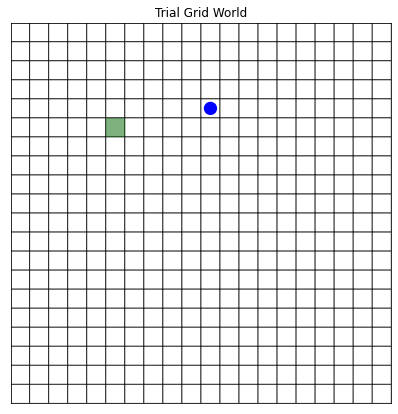

In [6]:
environment = 'gridworld:gridworld-v1'
env = gym.make(environment)
plt.show()
plt.close()


avdev_data = {}

for key in master_dict[environment].keys():
    v_list = master_dict[environment][key]
    avg_, std_ = get_avg_std(v_list)
    avdev_data[key] = [avg_, std_]


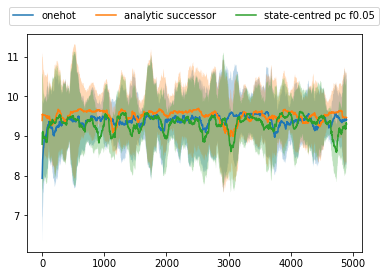

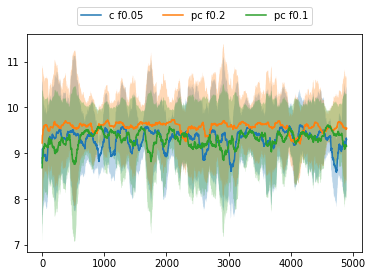

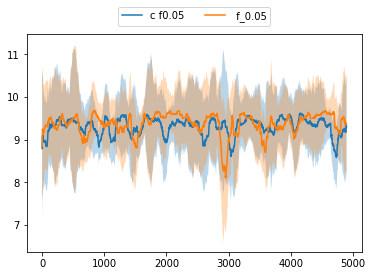

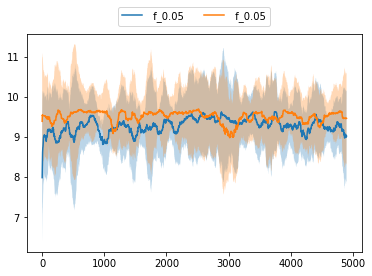

In [7]:
# compare 3 types
plt.figure()    
for key in ['onehot', 'analytic successor', 'state-centred pc f0.05']:
    avg_, std = avdev_data[key]
    label= key
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

# compare 3 types of state-centred pc 
plt.figure()    
for key in ['state-centred pc f0.05', 'state-centred pc f0.2', 'state-centred pc f0.1']:
    avg_, std = avdev_data[key]
    label= key[-7:]
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

# compare state-centred and random-centred plc
plt.figure()    
for key in ['state-centred pc f0.05', 'random-centred pc f_0.05']:
    avg_, std = avdev_data[key]
    label= key[-7:]
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

# compare analytic sr and td computed sr
plt.figure()    
for key in ['successor', 'analytic successor']:
    avg_, std = avdev_data[key]
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

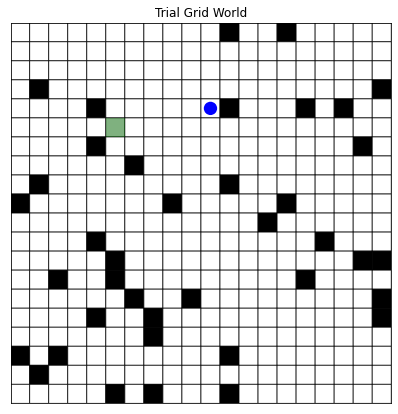

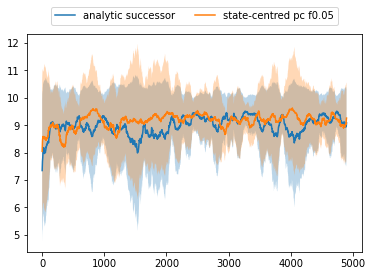

In [8]:
environment = 'gridworld:gridworld-v2'
env = gym.make(environment)
plt.show()
plt.close()

avdev_data = {}

for key in master_dict[environment].keys():
    v_list = master_dict[environment][key]
    avg_, std_ = get_avg_std(v_list)
    avdev_data[key] = [avg_, std_]

# compare 3 types
plt.figure()    
for key in ['analytic successor', 'state-centred pc f0.05']:
    avg_, std = avdev_data[key]
    label= key
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

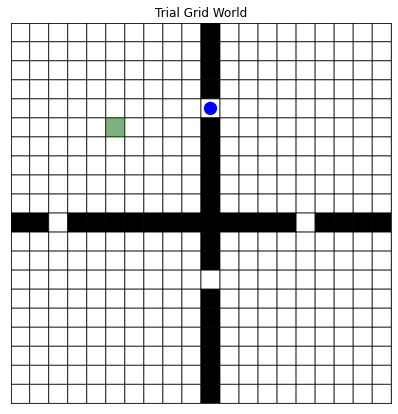

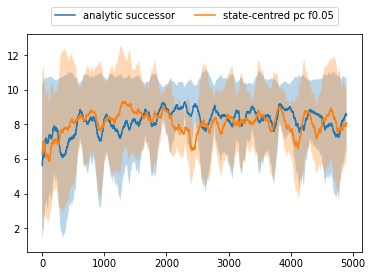

In [9]:
environment = 'gridworld:gridworld-v3'
env = gym.make(environment)
plt.show()
plt.close()

avdev_data = {}

for key in master_dict[environment].keys():
    v_list = master_dict[environment][key]
    avg_, std_ = get_avg_std(v_list)
    avdev_data[key] = [avg_, std_]

# compare 3 types
plt.figure()    
for key in ['analytic successor', 'state-centred pc f0.05']:
    avg_, std = avdev_data[key]
    label= key
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

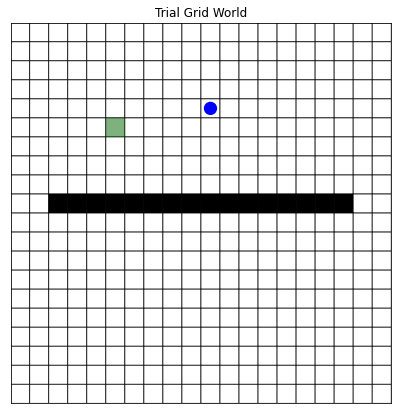

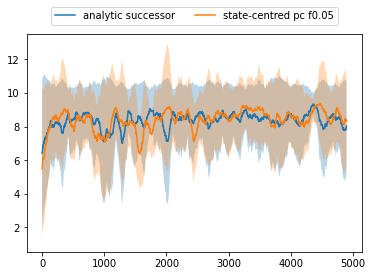

In [10]:
environment = 'gridworld:gridworld-v4'
env = gym.make(environment)
plt.show()
plt.close()

avdev_data = {}

for key in master_dict[environment].keys():
    v_list = master_dict[environment][key]
    avg_, std_ = get_avg_std(v_list)
    avdev_data[key] = [avg_, std_]

# compare 3 types
plt.figure()    
for key in ['analytic successor', 'state-centred pc f0.05']:
    avg_, std = avdev_data[key]
    label= key
    plt.plot(avg_, label=f'{label}')
    plt.fill_between(np.arange(len(avg_)),avg_-std_, avg_+std_, alpha=0.3)

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=4)
plt.show()

In [48]:
id_num = master_dict[envs[0]]['analytic successor'][0]

with open(data_dir+ f'{id_num}_data.p', 'rb') as f:
    dats = pickle.load(f)

In [49]:
from Utils.gridworld_plotting import plot_pref_pol, plot_valmap, plot_polmap

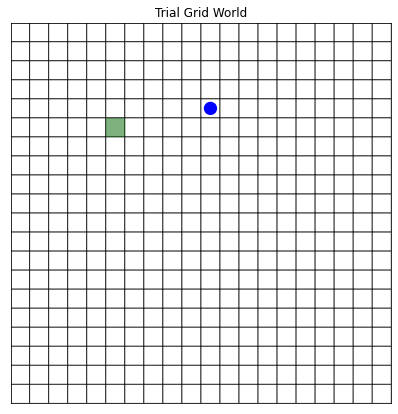

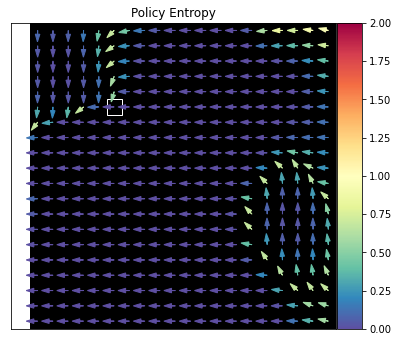

In [50]:
index = 4500
policies = dats['P_snap'][index]
values   = dats['V_snap'][index]
plot_pref_pol(gym.make(envs[0]),policies)

In [58]:
tot_rwd = []
for index in range(5000):
    policies = dats['P_snap'][index]
    reward_sum = 0 
    for step in range(250):
        action = np.random.choice(np.arange(4), 1, p=softmax(list(policies[env.oneD2twoD(env.state)])))[0]
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        if done:
            break
    tot_rwd.append(reward_sum)

TypeError: invalid type promotion

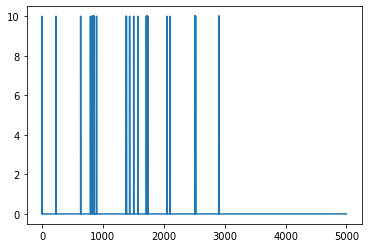

In [52]:
plt.figure()
plt.plot(tot_rwd)
plt.show()

In [54]:
np.asarray(list((0.2, 0.1, 0.1))) - np.asarray(list((0.1, 0.2,0.2)))

array([ 0.1, -0.1, -0.1])

[0.25466627 0.24726011 0.25054595 0.24752772] <class 'numpy.ndarray'>
[0.25116817 0.24931485 0.25013541 0.24938158] <class 'numpy.ndarray'>
[ 0.0034981  -0.00205474  0.00041054 -0.00185386]
